In [1]:
import numpy as np
import scipy.sparse
import pysindy as ps
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve # для поиска стационарных точек в бифф диагр

# Система Рёсслера
    Аттрактор Рёсслера - хаотический аттрактор, которым обладает система дифференциальных уравнений Рёсслера.
    При значениях параметров a = b = 0.2 && 2.6 <= c <= 4.2 уравнения Рёсслера обладают устойчивым предельным циклом.

In [2]:
def rossler(state, t, a=0.2, b=0.2, c=4.0):
    x, y, z = state
    return -y - z, x + a * y, b + z * (x - c)

## Биффуркационная диаграмма системы (не сделана)

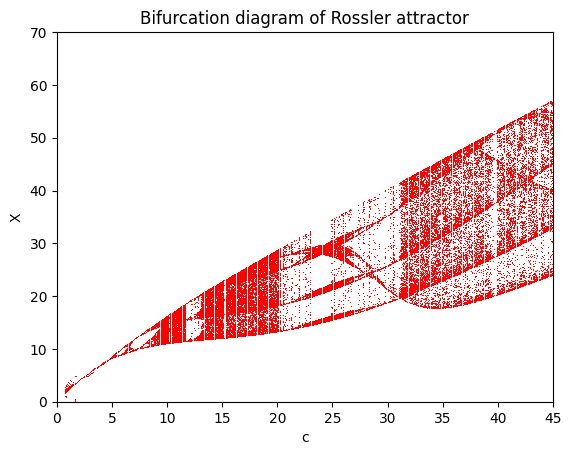

In [3]:
def main():
    t0 = 0.0
    dt = 0.001
    t_final = 1500
    T = np.arange(t0, t_final, dt)
    a, b = 0.1, 0.1
    ax = plt.figure().add_subplot(111)
    plt.xlim([0, 45])
    plt.ylim([0, 70])
    plt.xlabel('c')
    plt.ylabel('X')

    C = []
    X = []
    e = 1e-2
    c = 0.0
    while c < 45.0:
        x, y, z = 5.8, 1.0, 0.0
        counter = 10
        # the first 10 points may contain outliers
        for t in T:
            new_x = x + (-y - z) * dt
            new_y = y + (x + a*y) * dt
            new_z = z + (b + z*(x-c)) * dt
            if 0 <= new_x < 70 and abs(new_y) < e:
                if counter==0:
                    C.append(c)
                    X.append(new_x)
                else:
                    counter-=1
            x, y, z = new_x, new_y, new_z
        c += 0.1

    plt.plot(C, X, ',', color='red')
    plt.title('Bifurcation diagram of Rossler attractor')
    plt.show()

main()

## Построение графиков

In [51]:
def plot_time_series(x_train, time_steps, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series)):
        time_series[i].plot(time_steps, x_train[:, i])
        time_series[i].grid()
        time_series[i].set_xlabel('t')
        time_series[i].set_ylabel(ylabel[i])


def plot_time_series_comparison(x_train, x_sim, time_steps, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series)):
        time_series[i].plot(time_steps, x_train[:, i])
        time_series[i].plot(time_steps, x_sim[:, i], '--')
        time_series[i].grid()
        time_series[i].set_xlabel('t')
        time_series[i].set_ylabel(ylabel[i])


def plot_solution(x_train, initial_condition, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series) - 1):
        time_series[i].plot(x_train[:, 0], x_train[:, i + 1], label='Ground truth')
        time_series[i].plot(initial_condition[0], initial_condition[i + 1], "ko", label="Initial condition")
        time_series[i].set_xlabel('x')
        time_series[i].set_ylabel(ylabel[i + 1])
        time_series[i].grid()

    time_series[2].plot(x_train[:, 1], x_train[:, 2], label='Ground truth')
    time_series[2].plot(initial_condition[1], initial_condition[2], "ko", label="Initial condition")
    time_series[2].set_xlabel(ylabel[1])
    time_series[2].set_ylabel(ylabel[2])
    time_series[2].grid()

    time_series[0].legend()
    plt.show()


def plot_solution_comparison(x_train, x_sim, initial_condition, ylabel=['x', 'y', 'z'], method='Nothing'):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series) - 1):
        time_series[i].plot(x_train[:, 0], x_train[:, i + 1], label='Ground truth')
        time_series[i].plot(x_sim[:, 0], x_sim[:, i + 1], '--', label=method)
        time_series[i].plot(initial_condition[0], initial_condition[i + 1], "ko", label="Initial condition")
        time_series[i].set_xlabel('x')
        time_series[i].set_ylabel(ylabel[i + 1])
        time_series[i].grid()

    time_series[2].plot(x_train[:, 1], x_train[:, 2], label='Ground truth')
    time_series[2].plot(x_sim[:, 1], x_sim[:, 2], '--', label=method)
    time_series[2].plot(initial_condition[1], initial_condition[2], "ko", label="Initial condition")
    time_series[2].set_xlabel(ylabel[1])
    time_series[2].set_ylabel(ylabel[2])
    time_series[2].grid()

    time_series[0].legend()
    plt.show()

def plot_3D_solution(x_train):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Rossler Attractor')
    plt.show()

def plot_3D_solution_comparison(x_train, x_sim, method='Nothing'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
    ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], '--', label=method)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Rossler Attractor')
    plt.legend()
    plt.show()

## Алгоритмы аппроксимации

In [49]:
# x_train - np.array([],[],[]) временной ряд
# time - np.array[0, T] с шагом dt, time[0] = 0, time[1] = time[0] + dt
def ps_sol(x_train, time, optimizer=ps.optimizers.STLSQ(0.01), feature_library=ps.PolynomialLibrary(2),
           feature_names=('x', 'y', 'z'), differentiation_method=ps.differentiation.FiniteDifference(2)):
    model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names, differentiation_method=differentiation_method)
    model.fit(x_train, time)
    model.print()
    return model

True sys: 
 x' = -y - z 
 y' = x + 0.1 y 
 z' = 0.1 + z (x - 1)
(20000, 3)
(x)' = -1.000 y + -1.000 z
(y)' = 1.000 x + 0.100 y
(z)' = 0.100 1 + -1.000 z + 1.000 x z


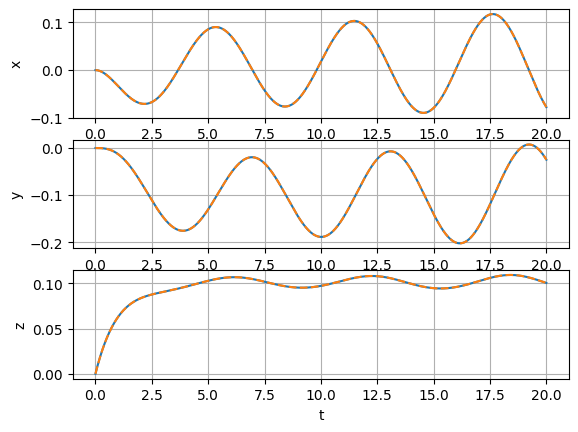

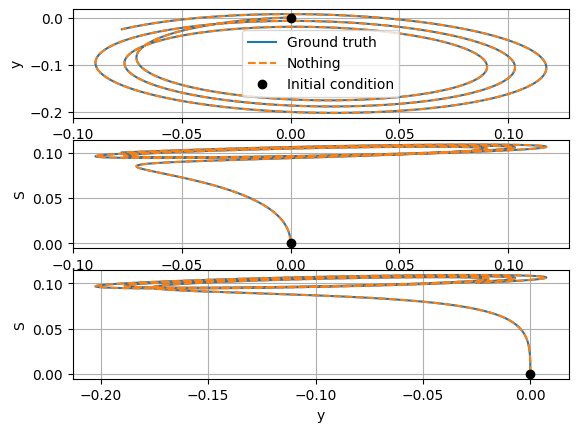

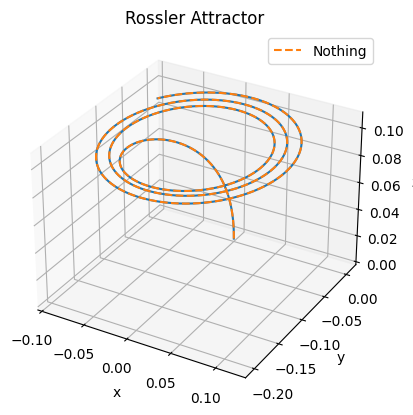

In [52]:
def main(param, state, time_s):
    a, b, c = param # 0.2, 0.4 отрабатывает нормаль

    state0 = state
    time_steps = time_s
    print(f"True sys: \n x' = -y - z \n y' = x + {a} y \n z' = {b} + z (x - {c})")
    x_train = odeint(rossler, state0, time_steps, args=(a, b, c))
    print(x_train.shape)
    model_ps = ps_sol(x_train, time_steps) # попробовать другой optimizer, например FROLS
    x_sim = model_ps.simulate(state0, time_steps)
    #plot_time_series(x_train, time_steps)
    #plot_solution(x_train, state0, 'pySINDY')
    #plot_3D_solution(x_train)

    plot_time_series_comparison(x_train, x_sim, time_steps)
    plot_solution_comparison(x_train, x_sim, state0, 'pySINDY')
    plot_3D_solution_comparison(x_train, x_sim)

main([0.1, 0.1, 1], [0,0,0], np.arange(0, 20, 0.001))

In [ ]:
import numpy as np

# Определяем систему уравнений для аттрактора Рёсслера
def rossler(t, y, a=0.2, b=0.2, c=4):
    x, y, z = y
    return np.array([-y - z, x + a*y, b + z*(x - c)])

# Интегрируем систему уравнений для получения временных рядов
t_span = [0, 100]
y0 = [0, 1, 1]
sol = solve_ivp(rossler, t_span, y0, t_eval=np.linspace(0, 50, 10000))

# Определяем параметры резервуарных вычислений
reservoir_size = 1000  # Размер резервуара
spectral_radius = 0.8  # Спектральный радиус матрицы связей
input_scaling = 0.5  # Масштабирование входного сигнала
leaking_rate = 0.3  # Коэффициент утечки

# Инициализируем матрицу связей резервуара
W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(W_res)))

# Инициализируем векторы входных и выходных сигналов резервуара
u_res = np.zeros((reservoir_size, 1))
x_res = np.zeros((reservoir_size, 1))

# Инициализируем матрицу обучения
X = np.zeros((reservoir_size + 1, sol.y.shape[1]))

# Инициализируем резервуар случайными значениями
x_res[:, 0] = np.random.rand(reservoir_size)

# Проходим по всем точкам временного ряда и обновляем состояние резервуара
for i in range(1, sol.y.shape[1]):
    # Обновляем входной сигнал резервуара
    u_res = input_scaling * sol.y[:, i].reshape(-1, 1)

    # Вычисляем новое состояние резервуара
    x_res = (1 - leaking_rate) * x_res + leaking_rate * np.tanh(np.dot(W_res, x_res) + np.dot(u_res, sol.t[i]))

    # Добавляем текущее состояние резервуара в матрицу обучения
    X[:, i] = np.concatenate((x_res.ravel(), [1]))

# Используем метод наименьших квадратов для аппроксимации временного ряда
Y = sol.y.T
W_out = np.dot(np.linalg.inv(np.dot(X, X.T)), np.dot(X, Y))

# Примен

In [75]:
def tmp(param):
    a, b, c = param
    state0 = [1,1,1]
    time_steps = np.arange(0, 45, 0.001)
    trajectory = odeint(rossler, state0, time_steps, args=(a, b, c))
    plot_time_series(trajectory, time_steps)
    plot_3D_solution(trajectory)

    _, time_series = plt.subplots(nrows=1, ncols=1)
    time_series.plot(trajectory[:, 0], trajectory[ :, 1])
    time_series.grid()

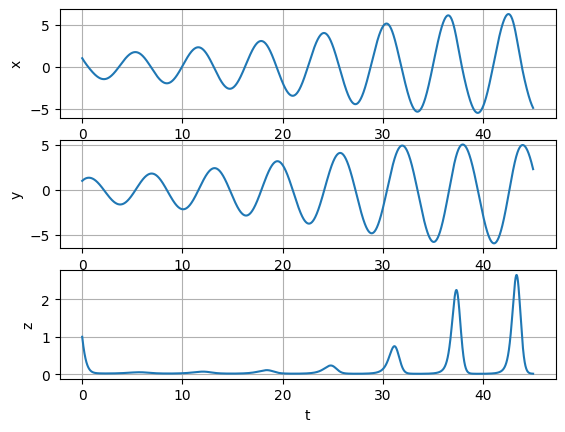

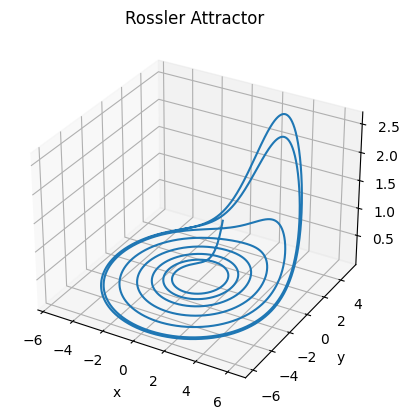

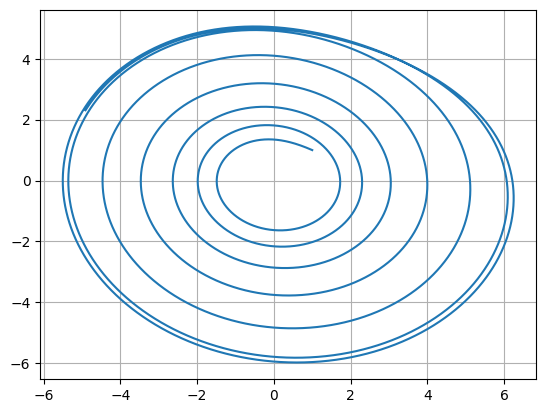

In [76]:
tmp([0.1, 0.1, 3.5])